In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list -s "Gender Classification 200K Images | CelebA"
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -qq celeba-dataset.zip

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ashishjangra27/gender-recognition-200k-images-celeba         Gender Classification 200K Images | CelebA            1GB  2020-05-22 20:15:23           5068         55  0.8125           
farzanansari/haar-cascade-gender-classification-200k-celeba  Haar Cascade | Gender Classification 200K | CelebA  294MB  2023-11-14 15:27:28             11          1  0.5625           
hongtrung/large-gender-face-dataset                          large gender face dataset                             3GB  2022-10-07 13:47:47            104          0  0.375            
100% 1.33G/1.33G [00:09<00:00, 198MB/s]
100% 1.33G/1.33G [00:09<00:00, 156M

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.activations import tanh, softmax
from keras import losses

In [ ]:
import os
import glob
from IPython import display

import imageio
import PIL
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
DATASET_PATH = '/content/img_align_celeba/img_align_celeba'
INPUT_SHAPE = (64, 64, 3)
images_list = []

for image_name in tqdm(os.listdir(DATASET_PATH)[:70000]):
    img = cv.imread(os.path.join(DATASET_PATH, image_name))
    img = cv.resize(img, INPUT_SHAPE[:2])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images_list.append(img)

  0%|          | 0/70000 [00:00<?, ?it/s]

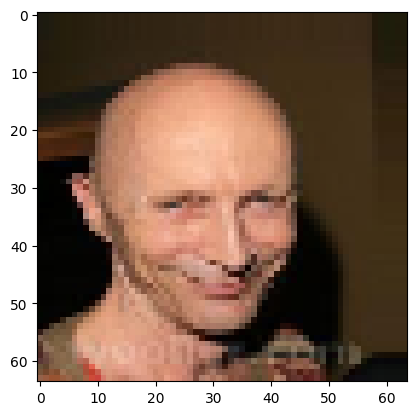

In [ ]:
plt.imshow(images_list[10])
plt.show()

In [ ]:
train_images = np.array(images_list).astype(np.float32)
del images_list
train_images = (train_images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
del train_images

In [ ]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), use_bias=False, padding='same'))
    assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), use_bias=False, padding='same'))
    assert model.output_shape == (None, 16, 16, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), use_bias=False, padding='same'))
    assert model.output_shape == (None, 32, 32, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), activation=tanh, use_bias=False, padding='same'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

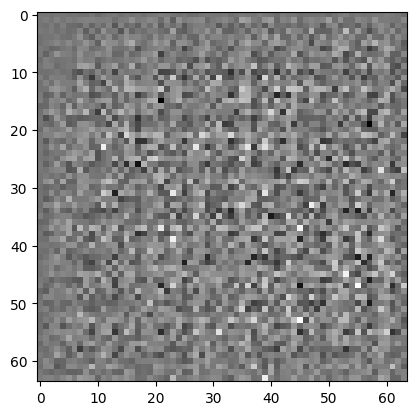

In [ ]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=INPUT_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(2, activation=softmax))

    return model

In [ ]:
discriminator = build_discriminator()
discriminator(generated_image)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5004913 , 0.49950868]], dtype=float32)>

In [ ]:
cross_entropy = losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [ ]:
EPOCHS = 100
NOISE_DIM = 100
NUM_EXAMPLE_TO_GENERATE = 16

seed = tf.random.normal([NUM_EXAMPLE_TO_GENERATE, NOISE_DIM])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_imgs = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_imgs, training=True)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.title(f'Epochs: {epoch}')
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        for imgs in dataset:
            train_step(imgs)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed)

        if epoch % 16 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

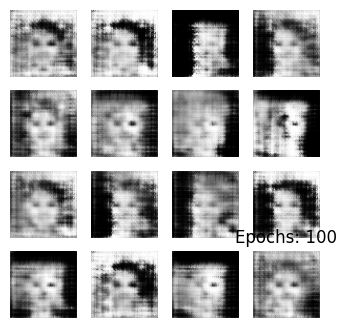

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
del train_dataset

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open(f'image_at_epoch_{epoch_no}.png')

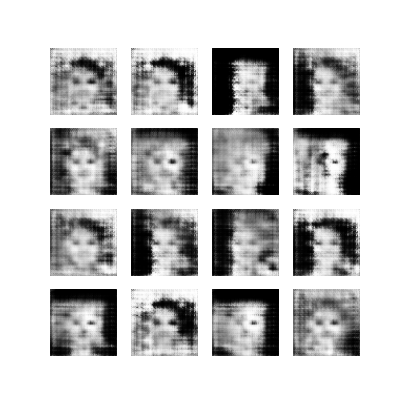

In [ ]:
display_image(EPOCHS)

In [ ]:
generator.save('best_celeb_a_generator_2')

In [ ]:
anim_file = 'Celeb_a_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)